In [106]:
import json
from collections import Counter, defaultdict
import os
import matplotlib.pyplot as plt
import numpy as np

In [107]:
def load_json(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)
    
def set_custom_color_style():
    
    blues = ["#21638f",
            "#004e98",
            "#102c9d",
            "#000058",
            "#93c8ee",
            "#4d90d3"]
    # Define a custom style for Matplotlib
    custom_style = {
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.grid": True,
        "axes.titlesize" : 10,
        "axes.labelsize" : 8,
        "lines.linewidth" : 3,
        "lines.markersize" : 10,
        "xtick.labelsize" : 6,
        "ytick.labelsize" : 6,
        "grid.alpha": 0.4,
        "grid.color": "gray",
        "lines.linewidth": 2,
        "lines.markersize": 6,
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor" : "black",
        #"figure.figsize": (8, 4),
        "axes.prop_cycle": plt.cycler("color", blues),  # Applying your blues palette
    }

    # Apply the style
    plt.style.use(custom_style)
    
def plot_statistics(stats, skier_label_distribution, avg_duration_per_label, avg_duration_per_skier_label, label_durations):
    
    set_custom_color_style()
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), width_ratios=[1, 2])
    
    # Plot Cycle Label Distribution
    axs[0,0].bar(stats["Cycle Label Distribution"].keys(), stats["Cycle Label Distribution"].values())
    axs[0,0].set_xlabel("Cycle Labels")
    axs[0,0].set_ylabel("Count")
    axs[0,0].set_title("Distribution of Cycle Labels")
    #axs[0,0].tick_params(rotation=45)

    
    # Plot Labels per Skier with stacked bars
    skiers = list(skier_label_distribution.keys())
    labels = list(set(label for labels in skier_label_distribution.values() for label in labels.keys()))
    
    skier_indices = np.arange(len(skiers))
    bottom_values = np.zeros(len(skiers))
    
    for label in labels:
        values = [skier_label_distribution[skier].get(label, 0) for skier in skiers]
        axs[0,1].bar(skiers, values, bottom=bottom_values, label=label)
        bottom_values += np.array(values)
    
    axs[0,1].set_xlabel("Skier ID")
    axs[0,1].set_ylabel("Number of Labels")
    axs[0,1].set_title("Number of Labels per Skier")
    axs[0,1].legend(title="Labels")
    
    # Plot Average Cycle Duration per Label
    axs[1,0].bar(avg_duration_per_label.keys(), avg_duration_per_label.values())
    axs[1,0].set_xlabel("Cycle Labels")
    axs[1,0].set_ylabel("Average Duration")
    axs[1,0].set_title("Average Cycle Duration per Label")
    #axs[1,0].tick_params(rotation=45)
    
    # Plot Average Cycle Duration per Skier with Label
    skiers = sorted(avg_duration_per_skier_label.keys())
    labels = sorted(set(label for skier_data in avg_duration_per_skier_label.values() for label in skier_data.keys()))
    
    width = 0.15
    x = np.arange(len(skiers))
    
    for i, label in enumerate(labels):
        values = [avg_duration_per_skier_label[skier].get(label, 0) for skier in skiers]
        axs[1,1].bar(x + i * width, values, width, label=label)
        
    # Plot line for average duration per skier
    avg_durations = [stats["Average Cycle Duration per Skier"].get(skier, 0) for skier in skiers]
    center_offset = (len(labels) - 1) / 2 * width  # Align line with center of grouped bars
    axs[1,1].plot(x + center_offset, avg_durations, color="black", marker="o", linestyle="-", label="Overall Avg")
    
    axs[1,1].set_xlabel("Skier ID")
    axs[1,1].set_ylabel("Average Cycle Duration")
    axs[1,1].set_title("Average Cycle Duration per Skier and Label")
    axs[1,1].set_xticks(x + width, skiers)
    axs[1,1].legend(title="Labels")
    
    fig.patch.set_facecolor('white')
    
    set_custom_color_style()
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # distribution of duration per label
    for i, label in enumerate(label_durations):
        if i >=2:
            i -= 2
            column = 1
        else:
            column = 0
        # Plotting the histogram
        axs[column,i].hist(label_durations[label], bins=20, edgecolor="black")
        axs[column,i].set_title(f'Distribution Cycle Lenght for Label: {label}')
        axs[column,i].set_xlabel('Cycle Length')
        axs[column,i].set_ylabel('Frequency')
    fig.patch.set_facecolor('white')
        

def compute_cycle_statistics(data):
    cycles = data.values()
    total_cycles = len(cycles)
    unique_skiers = len(set(entry["Skier_id"] for entry in cycles if "Skier_id" in entry))
    unique_videos = len(set(entry["Video"] for entry in cycles if "Video" in entry))
    
    label_counts = Counter(entry["Label"] for entry in cycles if "Label" in entry)
    durations = [entry["End_frame"] - entry["Start_frame"] for entry in cycles if "Start_frame" in entry and "End_frame" in entry]
    avg_duration = sum(durations) / len(durations) if durations else 0
    min_duration = min(durations) if durations else 0
    max_duration = max(durations) if durations else 0
    
    skier_cycles = Counter(entry["Skier_id"] for entry in cycles if "Skier_id" in entry)
    skier_durations = defaultdict(list)
    skier_label_distribution = defaultdict(Counter)
    label_durations = defaultdict(list)
    skier_label_durations = defaultdict(lambda: defaultdict(list))
    
    for entry in cycles:
        duration = entry["End_frame"] - entry["Start_frame"]
        if "Skier_id" in entry:
            skier_durations[entry["Skier_id"]].append(duration)
            skier_label_distribution[entry["Skier_id"]][entry["Label"]] += 1
            skier_label_durations[entry["Skier_id"]][entry["Label"]].append(duration)
        if "Label" in entry:
            label_durations[entry["Label"]].append(duration)
    
    avg_skier_durations = {skier: sum(times) / len(times) for skier, times in skier_durations.items()}
    avg_label_durations = {label: sum(times) / len(times) for label, times in label_durations.items()}
    avg_skier_label_durations = {
        skier: {label: sum(times) / len(times) for label, times in labels.items()} 
        for skier, labels in skier_label_durations.items()
    }
    
    return {
        "Total Cycles": total_cycles,
        "Unique Skiers": unique_skiers,
        "Unique Videos": unique_videos,
        "Cycle Label Distribution": dict(label_counts),
        "Average Cycle Duration": avg_duration,
        "Min Cycle Duration": min_duration,
        "Max Cycle Duration": max_duration,
        "Cycles per Skier": dict(skier_cycles),
        "Average Cycle Duration per Skier": avg_skier_durations,
    }, skier_label_distribution, avg_label_durations, avg_skier_label_durations, label_durations

## Statistics on Train set

Total Cycles: 1684
Unique Skiers: 12
Unique Videos: 140
Cycle Label Distribution: {'unknown': 339, 'gear2': 586, 'gear3': 634, 'gear4': 125}
Average Cycle Duration: 45.37885985748218
Min Cycle Duration: 15
Max Cycle Duration: 117
Cycles per Skier: {11: 173, 5: 162, 13: 230, 9: 102, 12: 149, 3: 169, 1: 67, 2: 76, 7: 152, 8: 310, 10: 65, 4: 29}
Average Cycle Duration per Skier: {11: 45.91907514450867, 5: 39.80246913580247, 13: 44.926086956521736, 9: 49.245098039215684, 12: 41.20805369127517, 3: 42.59171597633136, 1: 46.35820895522388, 2: 48.96052631578947, 7: 39.2171052631579, 8: 51.64193548387097, 10: 48.41538461538462, 4: 47.86206896551724}
Label: unknown, avg duration: 45.00589970501475, min duration: 16, max duration: 117
Label: gear2, avg duration: 33.96245733788396, min duration: 15, max duration: 78
Label: gear3, avg duration: 56.25078864353312, min duration: 36, max duration: 77
Label: gear4, avg duration: 44.768, min duration: 32, max duration: 56


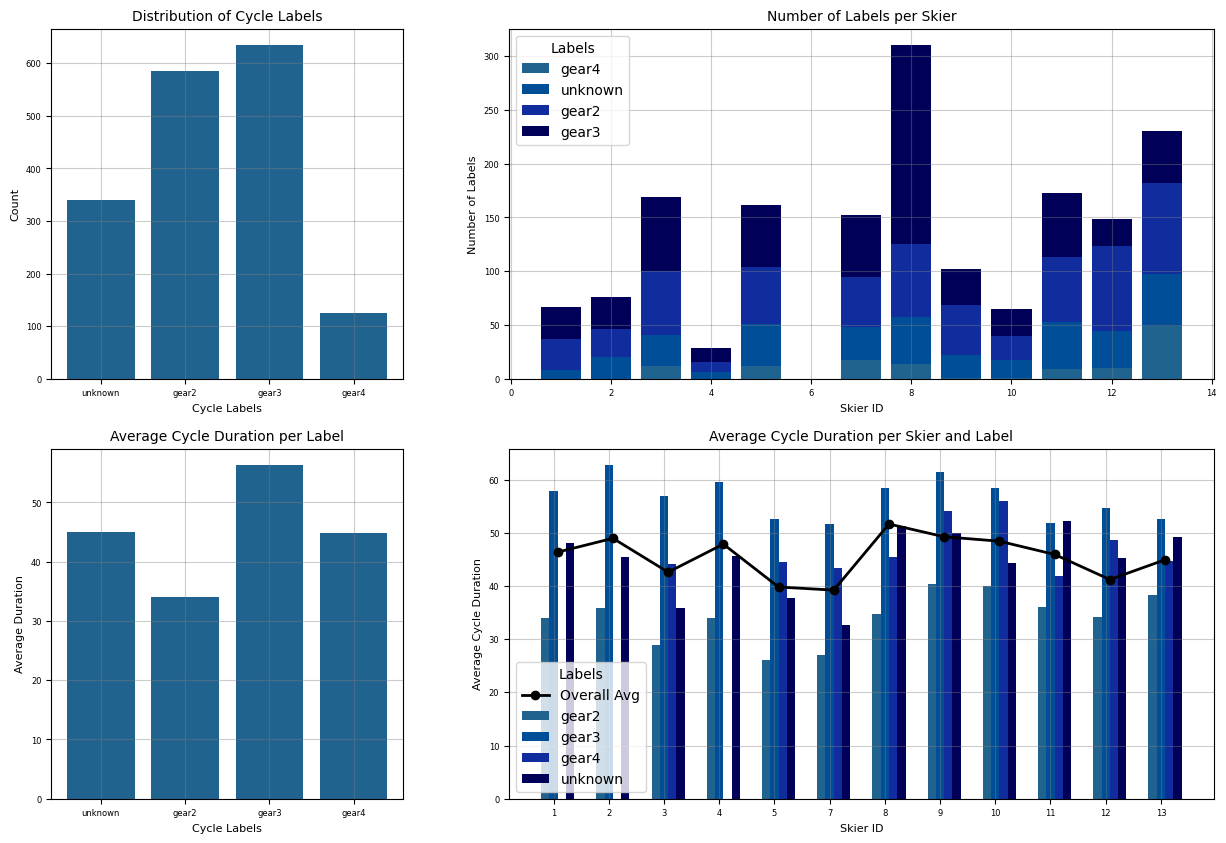

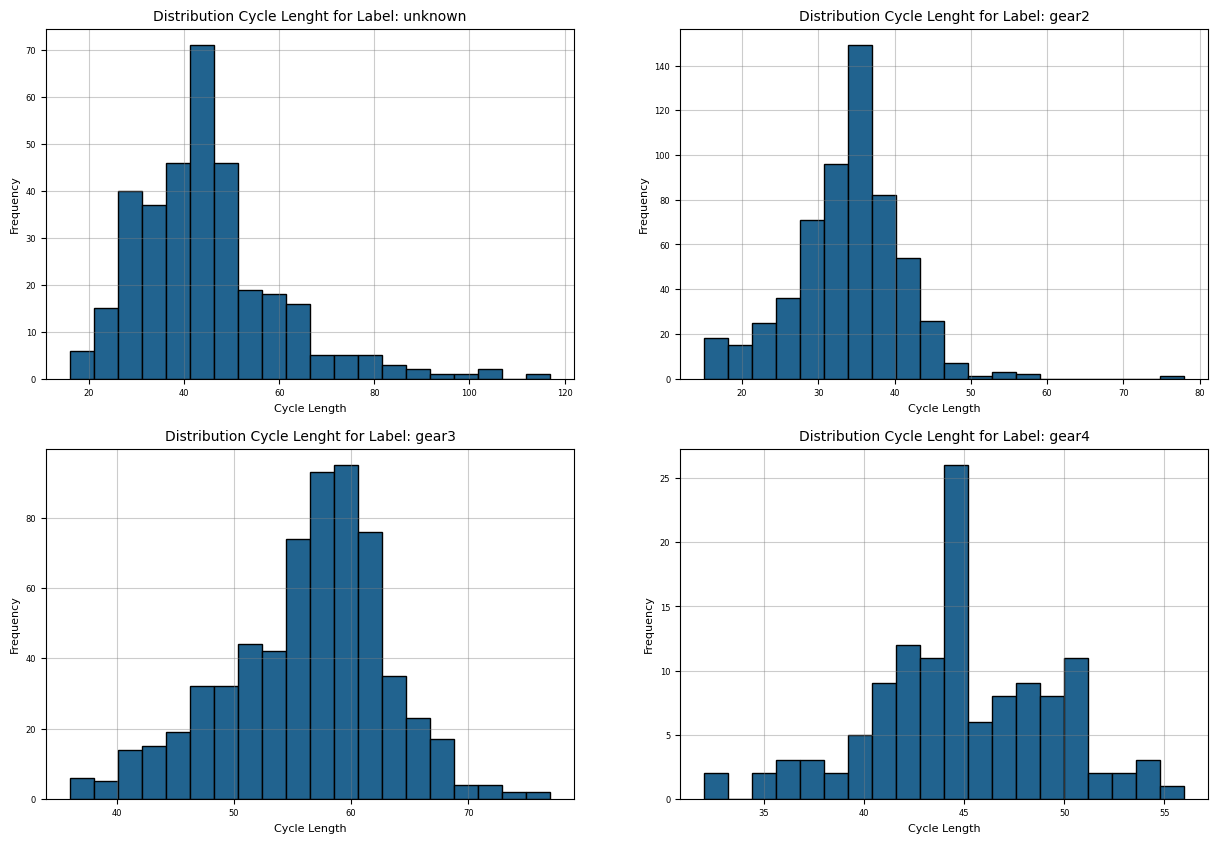

In [108]:
file_path = "../../data/split_data/train_full.json"  # Change this if needed
data = load_json(file_path)
stats, skier_label_distribution, avg_duration_per_label, avg_duration_per_skier_label, label_durations = compute_cycle_statistics(data)
for key, value in stats.items():
    print(f"{key}: {value}")
for label in label_durations:
    print(f"Label: {label}, avg duration: {np.mean(label_durations[label])}, min duration: {np.min(label_durations[label])}, max duration: {np.max(label_durations[label])}")
plot_statistics(stats, skier_label_distribution, avg_duration_per_label, avg_duration_per_skier_label, label_durations)

## Statistics on Test set

Total Cycles: 188
Unique Skiers: 11
Unique Videos: 102
Cycle Label Distribution: {'gear2': 66, 'gear3': 64, 'unknown': 43, 'gear4': 15}
Average Cycle Duration: 44.734042553191486
Min Cycle Duration: 15
Max Cycle Duration: 212
Cycles per Skier: {8: 30, 5: 24, 13: 22, 7: 29, 9: 14, 11: 19, 2: 7, 12: 14, 10: 4, 3: 23, 4: 2}
Average Cycle Duration per Skier: {8: 51.733333333333334, 5: 40.25, 13: 44.90909090909091, 7: 37.55172413793103, 9: 50.57142857142857, 11: 44.94736842105263, 2: 68.0, 12: 41.285714285714285, 10: 47.25, 3: 40.91304347826087, 4: 34.5}
Label: gear2, avg duration: 33.06060606060606, min duration: 15, max duration: 66
Label: gear3, avg duration: 54.15625, min duration: 38, max duration: 73
Label: unknown, avg duration: 48.93023255813954, min duration: 22, max duration: 212
Label: gear4, avg duration: 43.86666666666667, min duration: 38, max duration: 55


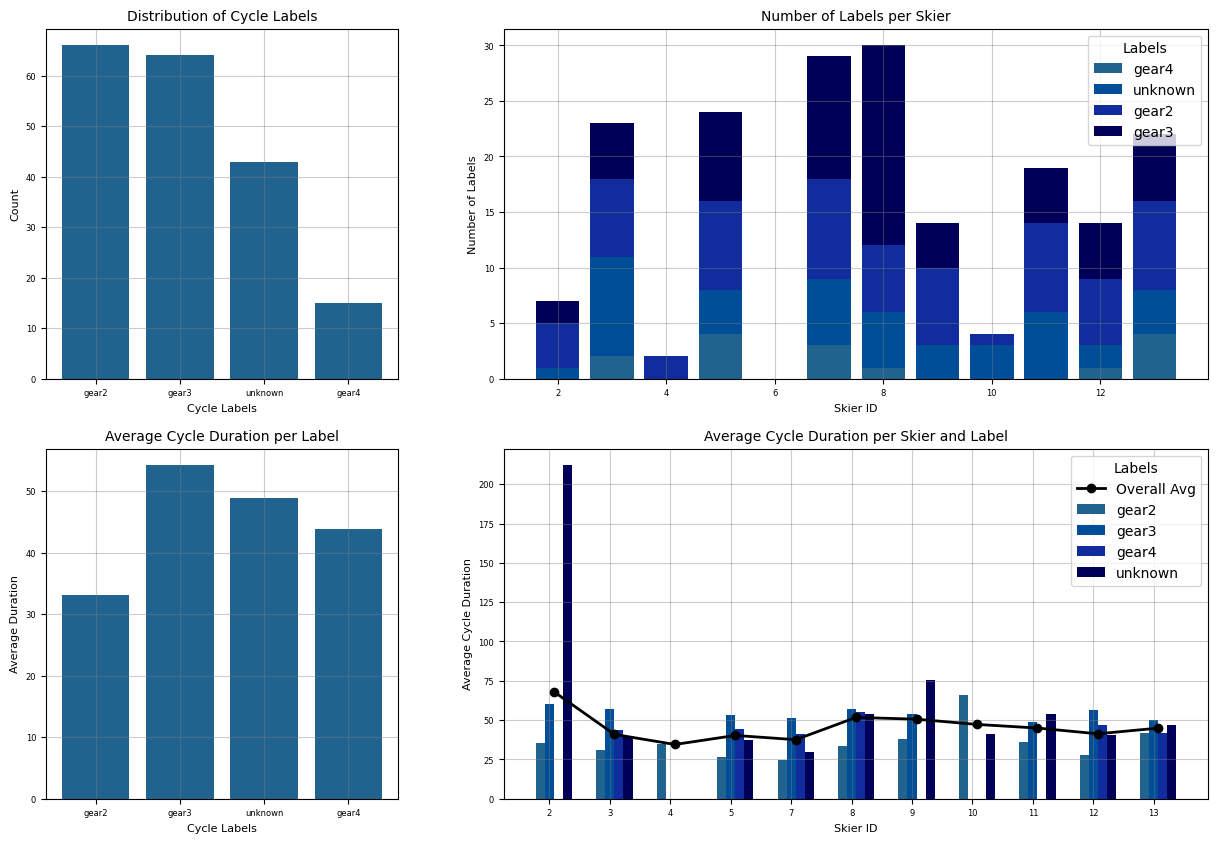

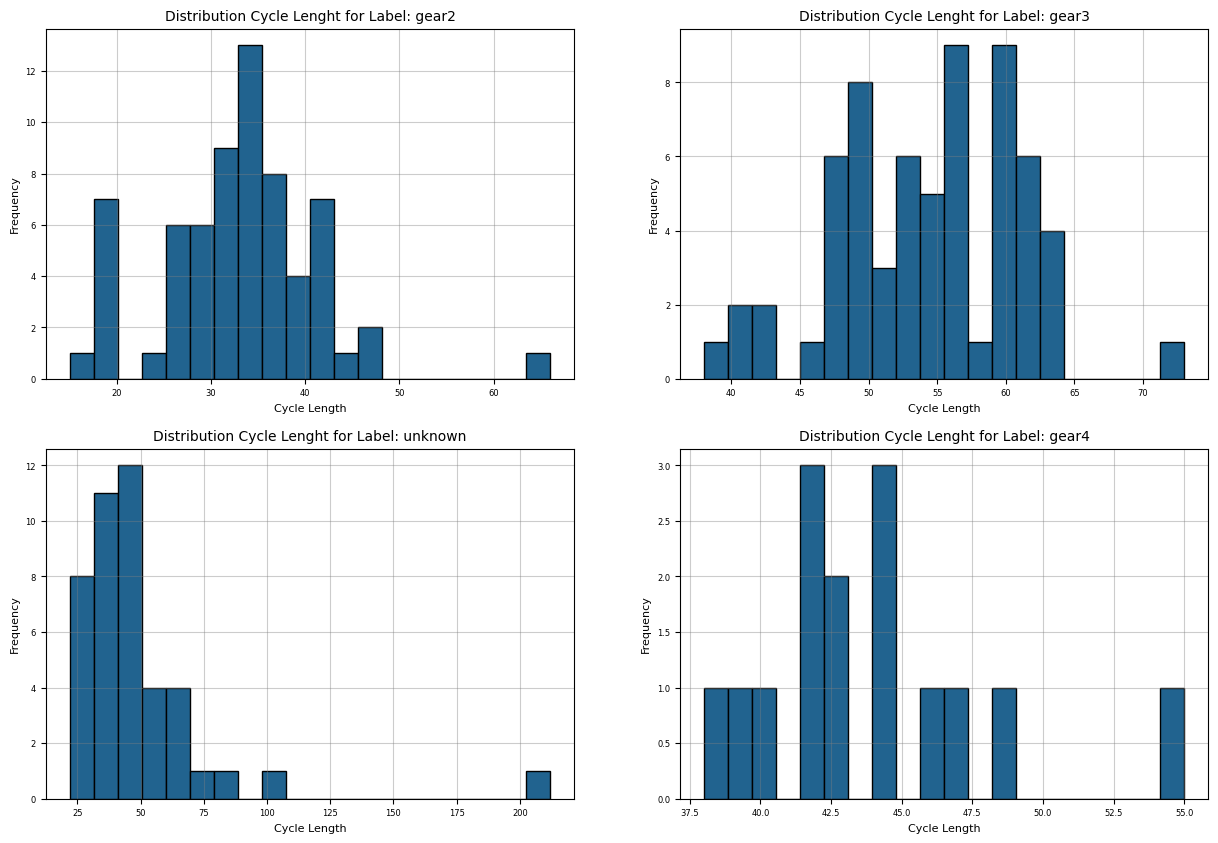

In [109]:
file_path = "../../data/split_data/test_full.json"  # Change this if needed
data = load_json(file_path)
stats, skier_label_distribution, avg_duration_per_label, avg_duration_per_skier_label, label_durations = compute_cycle_statistics(data)
for key, value in stats.items():
    print(f"{key}: {value}")
for label in label_durations:
    print(f"Label: {label}, avg duration: {np.mean(label_durations[label])}, min duration: {np.min(label_durations[label])}, max duration: {np.max(label_durations[label])}")
plot_statistics(stats, skier_label_distribution, avg_duration_per_label, avg_duration_per_skier_label, label_durations)